# **Advanced Lane Finding** 
***
As a part of the Udacity Self Driving Car Engineer Nanodegree program, we use computer vision to implement to again implement lane finding, but using a more advanced set of techniques than the first project of the course.

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. [Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.](#camera_calibration)
2. [Apply a distortion correction to raw images.](#apply_distortion)
3. [Use color transforms, gradients, etc., to create a thresholded binary image.](#create_binary)
4. [Apply a perspective transform to rectify binary image ("birds-eye view").](#perspective)
5. [Detect lane pixels and fit to find the lane boundary.](#fit_lane)
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

<a id='camera_calibration'></a>

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


def getpoints(imgfiles, nx, ny, drawcorners=False, allowoffbyone=True):
    '''Construct image points and object points from chessboard calibration image files'''
    imgpoints = []
    objpoints = []
    imgsize = None

    # prepare constant object points to append if corners found in an image
    objp = np.zeros((nx*ny,3), dtype=np.float32)
    objp[:,:2] = np.mgrid[:nx,:ny].T.reshape(-1,2)

    # Process images and build imgpoints list
    for imgfile in imgfiles:
        
        img = mpimg.imread(imgfile)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        this_imgsize = gray.shape[::-1]
        if imgsize is None:
            imgsize = this_imgsize # store (width, height) for use by cv2.calibrateCamera()
        else:
            msg = 'Size mismatch: {}. {} != {}.'.format(imgfile, imgsize, gray.shape[::-1])
            # a couple of the images have an extra pixel in each dimension, but it should be
            # ok since the corners are within the smaller dimension range?
            # Thus, let's optionally allow it.
            allowedsizes = [this_imgsize]
            if allowoffbyone:
                allowedsizes.append((this_imgsize[0] - 1, this_imgsize[1] - 1))
            assert imgsize in allowedsizes, msg

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners found, draw corners, and append corresponding img/obj points
        if ret:
            
            # Optionally plot the images with corners drawn
            if drawcorners:
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(img)
                plt.title(imgfile + ' corners')
            
            objpoints.append(objp)
            imgpoints.append(corners)
            
    
    return objpoints, imgpoints, imgsize

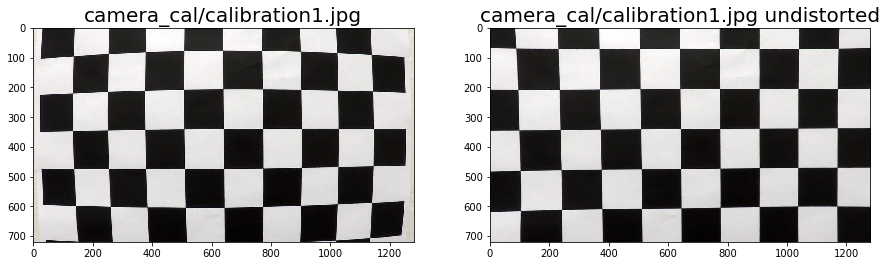

In [2]:
import glob
import os

# Make a list of calibration image files
imgfiles = glob.glob('camera_cal/calibration*.jpg')

# Get corresponding object/image points assuming 9x6 checkerboard
objpoints, imgpoints, imgsize = getpoints(imgfiles, nx=9, ny=6)

# Compute calibration matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)

# Load a calibration image and undistort it
examplefile = imgfiles[0]
img = mpimg.imread(examplefile)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Plot the before and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
ax1.imshow(img)
ax1.set_title(examplefile, fontsize=20)
ax2.imshow(dst)
ax2.set_title(examplefile + ' undistorted', fontsize=20)
name, ext = os.path.splitext(os.path.basename(examplefile))
fig.savefig('examples/' + name + '_undistortion' + ext, bbox_inches='tight')

assert ret, "Problem Calibrating Camera!"

## Pipeline (single images)

<a id='apply_distortion'></a>

### 2. Apply a distortion correction to raw images.

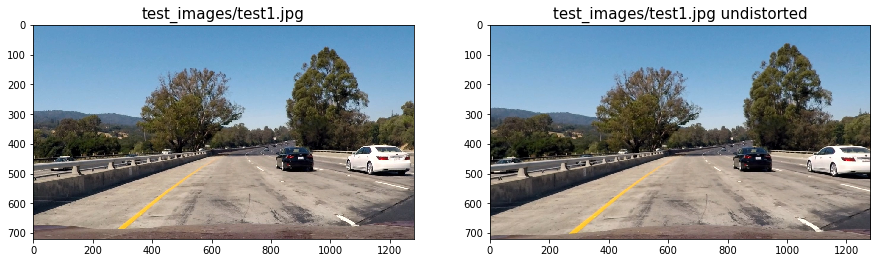

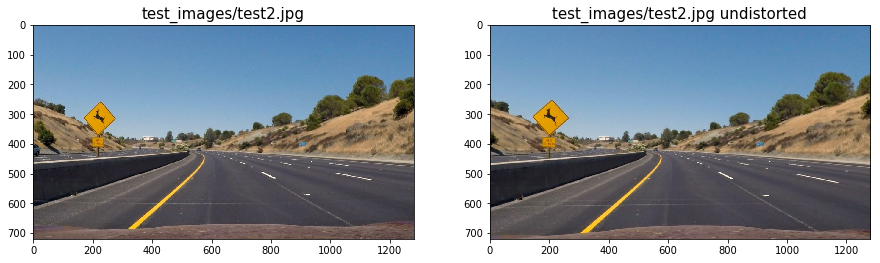

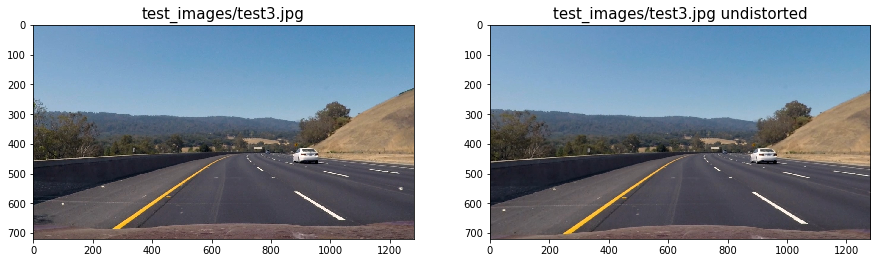

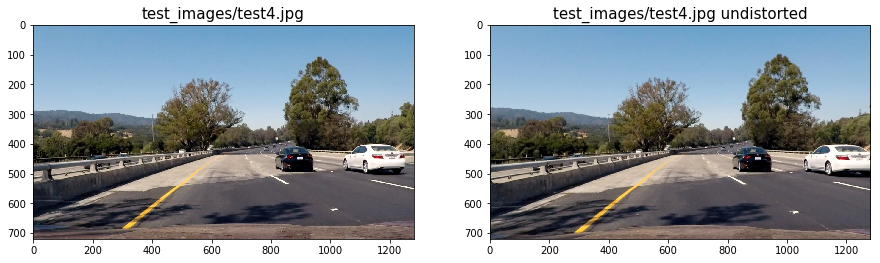

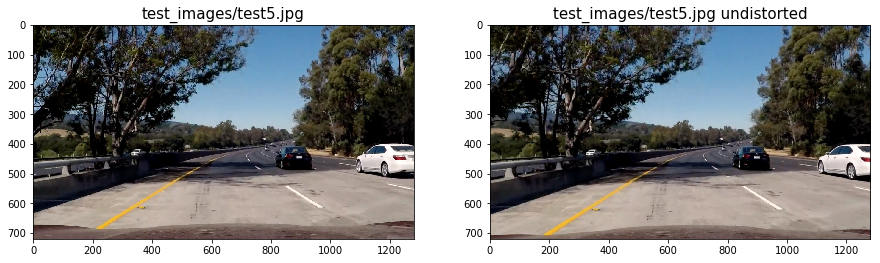

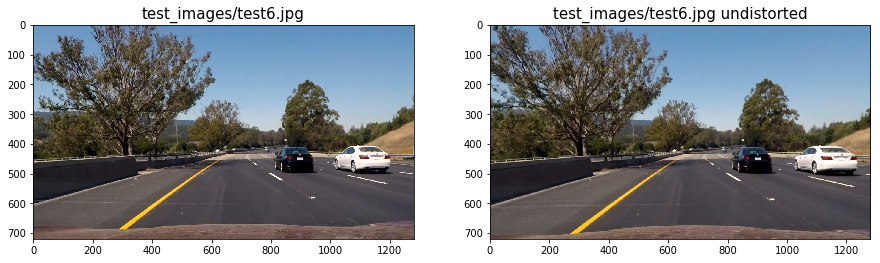

In [3]:
examplefiles = glob.glob('test_images/test*.jpg')

for examplefile in examplefiles:

    # Load a test image and undistort it
    img = mpimg.imread(examplefile)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Plot the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
    ax1.imshow(img)
    ax1.set_title(examplefile, fontsize=15)
    ax2.imshow(dst)
    ax2.set_title(examplefile + ' undistorted', fontsize=15)
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_undistortion' + ext, bbox_inches='tight')

<a id='create_binary'></a>

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [82]:
def get_color_channel(img, cvtmode, channel_idx=0):
    '''Apply desired color conversion and return the desired channel'''
    
    # Convert color space
    img_cvt = cv2.cvtColor(img, cvtmode)

    # Select desired color channel
    img_cvt = np.atleast_3d(img_cvt) # in case it's grayscale
    channel_img = img_cvt[:, :, channel_idx]
    
    return channel_img


def deriv_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255),
                     cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x or y, take the absolute value and apply thresholds
       to produce boolean pixel mask'''
    
    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Take the partial derivative wrt x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0)
    elif orient=='y':
        sobel = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1)
    else:
        raise ValueError("orient can be 'x' or 'y'")
    
    # Take the absolute value of that partial derivative
    abs_sobel = np.abs(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])
    
    return boolean_mask


def grad_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255),
                    cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x and y, compute the magnitude of the gradient
       and apply thresholds to produce boolean pixel mask'''

    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Compute the x and y components of the gradient
    sobelx = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * mag / mag.max())
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])

    return boolean_mask


def grad_dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2),
                    cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x and y, compute the gradient direction and apply
       thresholds to produce boolean pixel mask'''

    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (angle > thresh[0]) & (angle < thresh[1])

    return boolean_mask


def color_thresh(img, thresh=(0, 255), cvtmode=cv2.COLOR_RGB2HLS,
                 channel_idx=2):
    '''Optionally convert to another colorspace, then threshold the desired channel
       to produce a boolean pixel mask.
       By default it takes an RGB image, converts it to HLS and thresholds the
       S channel to produce a boolean pixel mask'''
    
    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (ch_img > thresh[0]) & (ch_img <= thresh[1])

    return boolean_mask


def get_pixel_mask(img):
    '''Use colorspace conversions, color thresholds and gradients to produce images mapped
       to max/min pixel values representing a boolean mask of selected pixels. Returns 
       gradient/color combined as well as stacked for debug/analysis.'''
    
    # Create boolean masks using each technique
    x_mask = deriv_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100),
                              cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    y_mask = deriv_mag_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100),
                              cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    mag_mask = grad_mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100),
                               cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    dir_mask = grad_dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3),
                               cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    color_mask = color_thresh(img, thresh=(170, 255), cvtmode=cv2.COLOR_RGB2HLS, channel_idx=2)

    # Combine the partial derivative and gradient magnitude and direction masks
    grad_mask = (x_mask) | (mag_mask & dir_mask)

    # Combine gradient and color masks
    grad_color_mask = grad_mask | color_mask
    
    # Create black and white image of the fully combined mask
    grad_color_img = np.dstack([np.uint8(grad_color_mask*255)]*3)
    
    # Create stacked image of color and grad masks for visualizing the contribution of each
    grad_color_img_stacked = np.dstack((np.zeros_like(grad_mask, np.uint8),
                                np.uint8(grad_mask*255),
                                np.uint8(color_mask*255)))
    
    return grad_color_img, grad_color_img_stacked
    
    

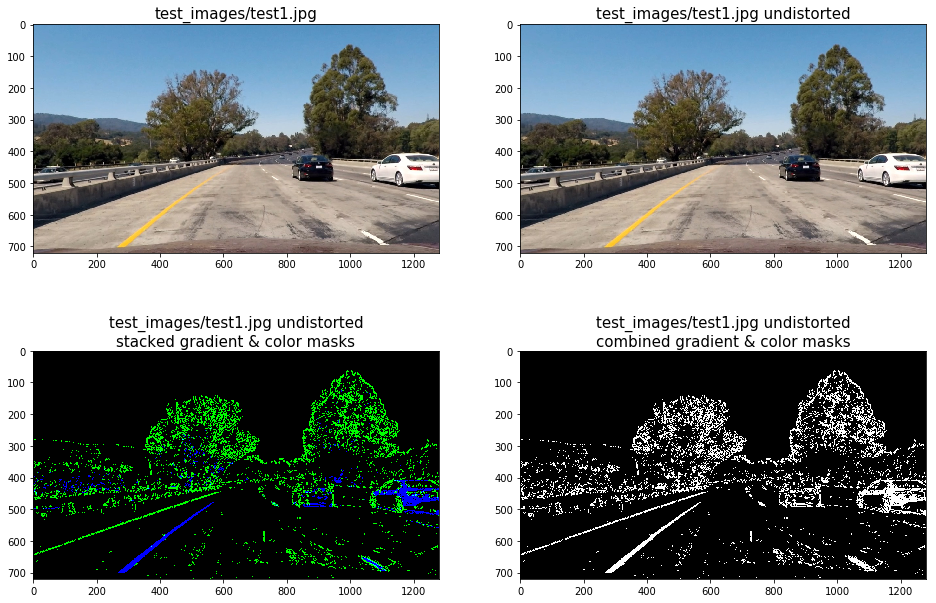

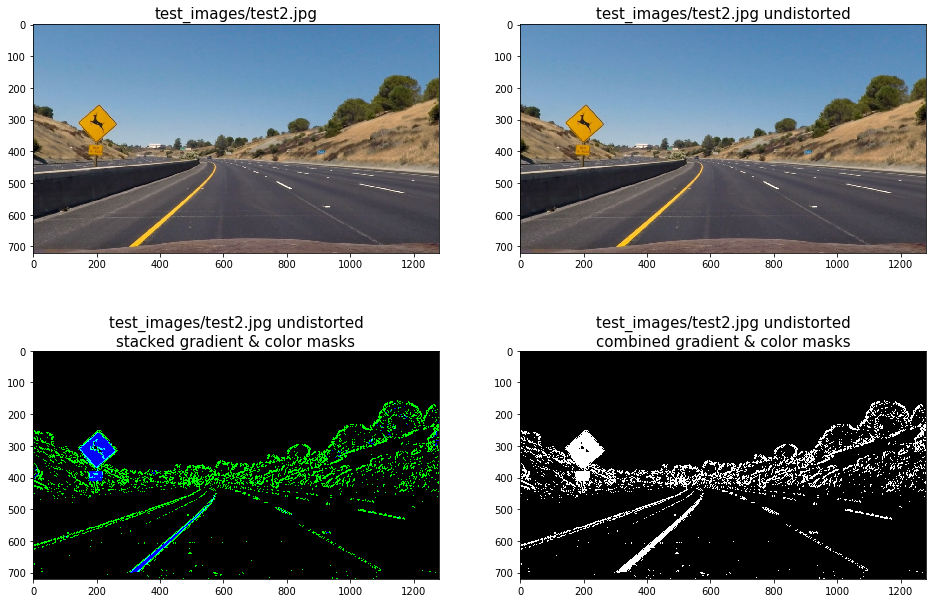

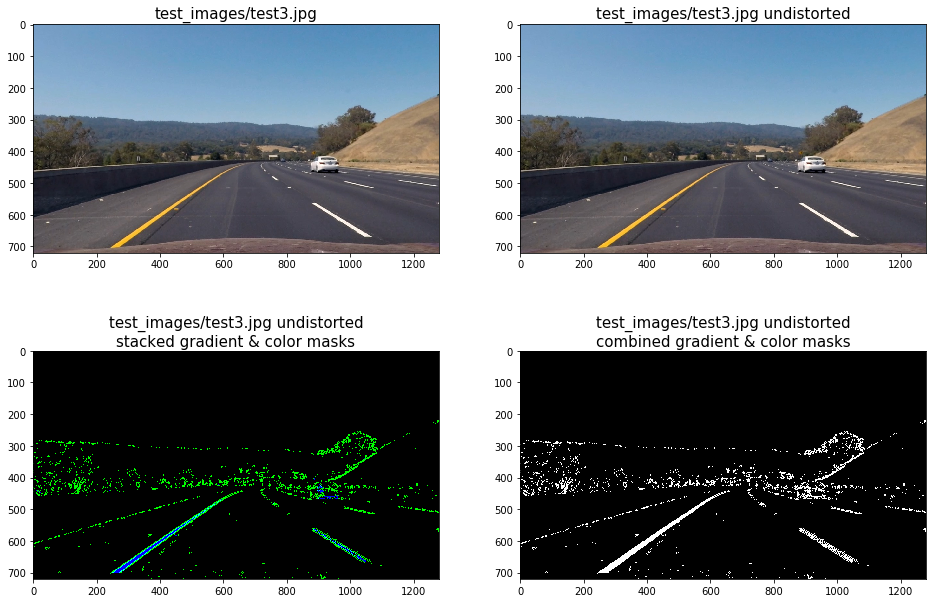

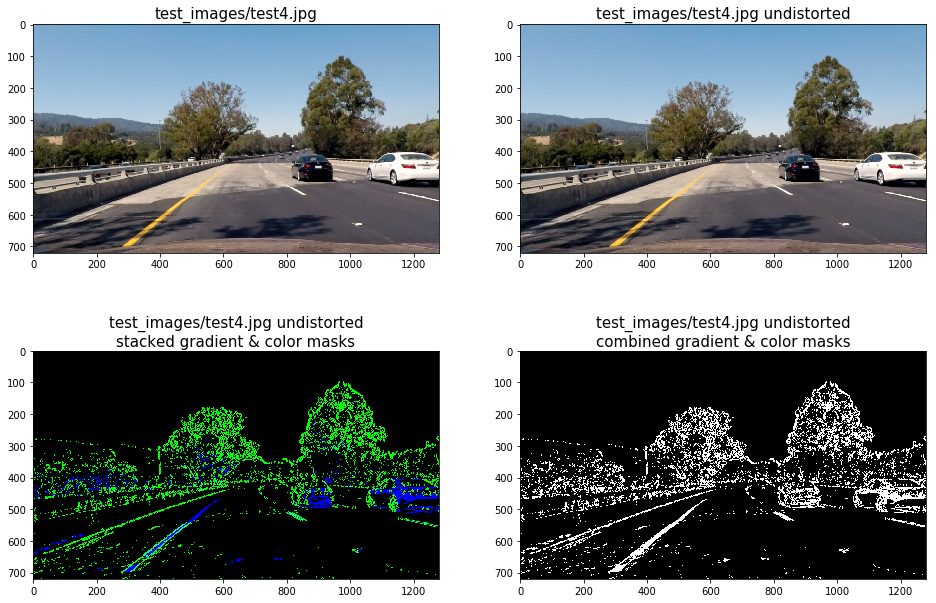

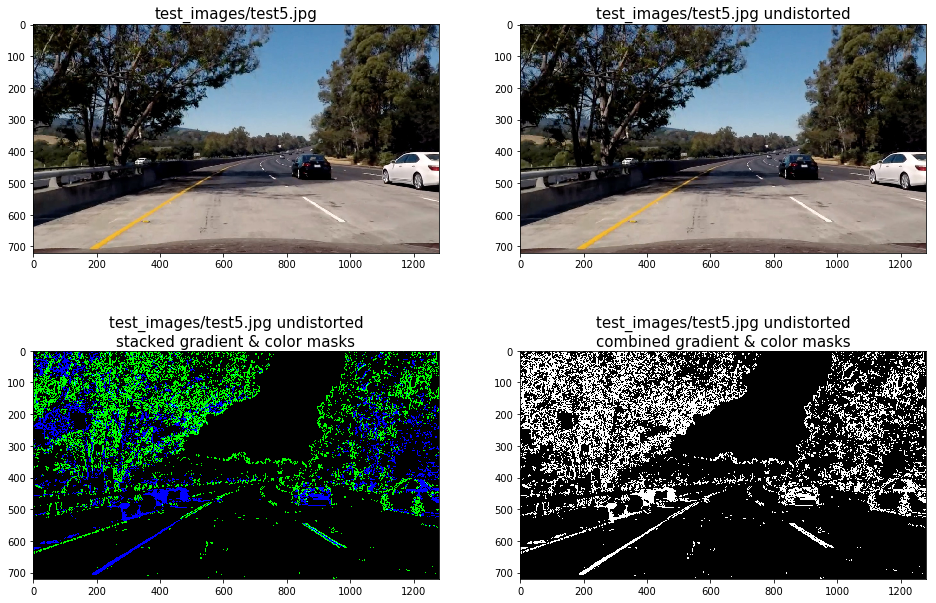

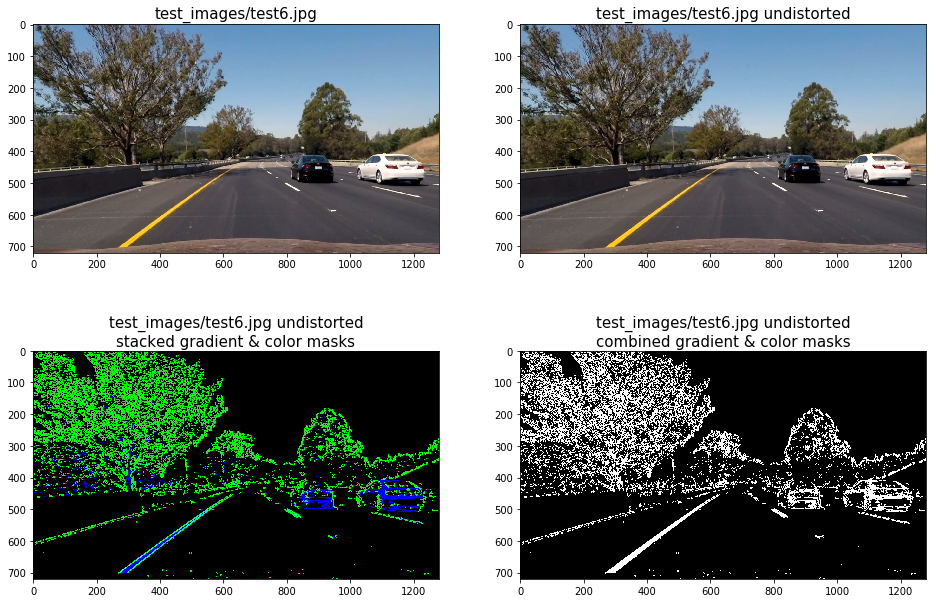

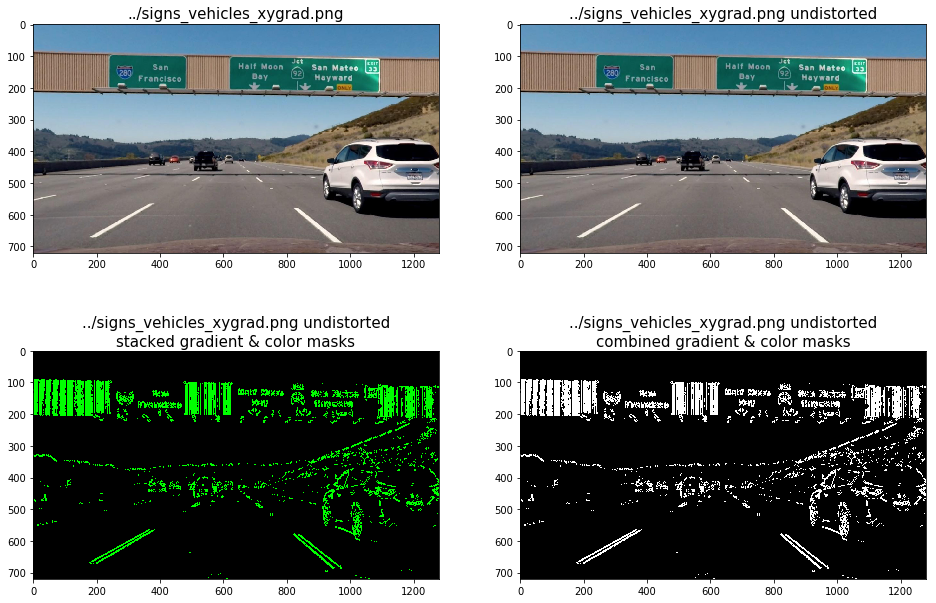

In [83]:
examplefiles = ['../signs_vehicles_xygrad.png'] + glob.glob('test_images/test*.jpg')

for examplefile in examplefiles:
    
    # Load a test image
    img = mpimg.imread(examplefile)
    
    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask images
    combined, stacked = get_pixel_mask(dst)

    # Plot the before and after
    fig, ax = plt.subplots(2, 2, figsize=(16,11))
    ax[0,0].imshow(dst)
    ax[0,0].set_title(examplefile, fontsize=15)
    ax[0,1].imshow(dst)
    ax[0,1].set_title(examplefile + ' undistorted', fontsize=15)
    ax[1,0].imshow(stacked)
    ax[1,0].set_title(examplefile + ' undistorted\nstacked gradient & color masks', fontsize=15)
    ax[1,1].imshow(combined)
    ax[1,1].set_title(examplefile + ' undistorted\ncombined gradient & color masks', fontsize=15)
    
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_binary' + ext, bbox_inches='tight')

<a id='perspective'></a>

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [84]:
import tabulate

# src points rectangle vertices
srcpoints = np.float32(
    [[(imgsize[0] / 2) - 60, imgsize[1] / 2 + 100],
    [((imgsize[0] / 6) - 10), imgsize[1]],
    [(imgsize[0] * 5 / 6) + 40, imgsize[1]],
    [(imgsize[0] / 2 + 64), imgsize[1] / 2 + 100]])

# dst points rectangle vertices
dstpoints = np.float32(
    [[(imgsize[0] / 4), 0],
    [(imgsize[0] / 4), imgsize[1]],
    [(imgsize[0] * 3 / 4), imgsize[1]],
    [(imgsize[0] * 3 / 4), 0]])

print(tabulate.tabulate({'srcpoints':srcpoints, 'dstpoints':dstpoints},
                        headers='keys', tablefmt='pipe'))

# Compute perspective transform matrix, M
M = cv2.getPerspectiveTransform(srcpoints, dstpoints)

| srcpoints                       | dstpoints     |
|:--------------------------------|:--------------|
| [ 580.  460.]                   | [ 320.    0.] |
| [ 203.33332825  720.        ]   | [ 320.  720.] |
| [ 1106.66662598   720.        ] | [ 960.  720.] |
| [ 704.  460.]                   | [ 960.    0.] |


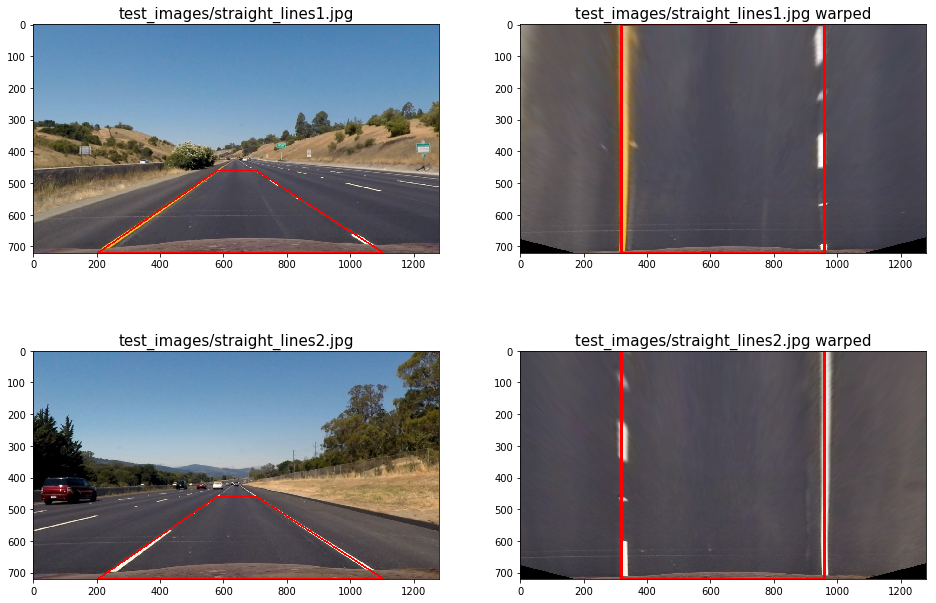

In [85]:
straight_examplefiles = glob.glob('test_images/straight_lines*.jpg')

# Create subplot axes with appropriate shape and size
fig, ax = plt.subplots(2, 2, figsize=(16, 11))

for idx, examplefile in enumerate(straight_examplefiles):
    
    # load image
    img = mpimg.imread(examplefile)
    
    # correct for camera distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Warp image perspective to a top-down view
    warped = cv2.warpPerspective(undist, M, imgsize, flags=cv2.INTER_LINEAR)
    
    # Draw source and destination point "rectangles"
    cv2.polylines(undist,[srcpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=4)
    cv2.polylines(warped,[dstpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=8)
    
    # Plot them
    ax[idx,0].imshow(undist)
    ax[idx,0].set_title(examplefile, fontsize=15)
    ax[idx,1].imshow(warped)
    ax[idx,1].set_title(examplefile + ' warped', fontsize=15)
    
fig.savefig('examples/straight_lines_warped.jpg', bbox_inches='tight')

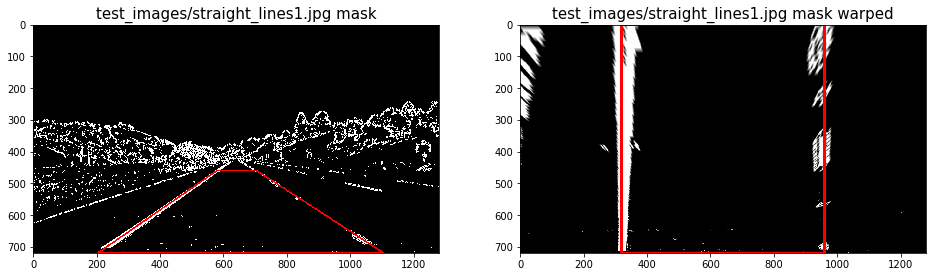

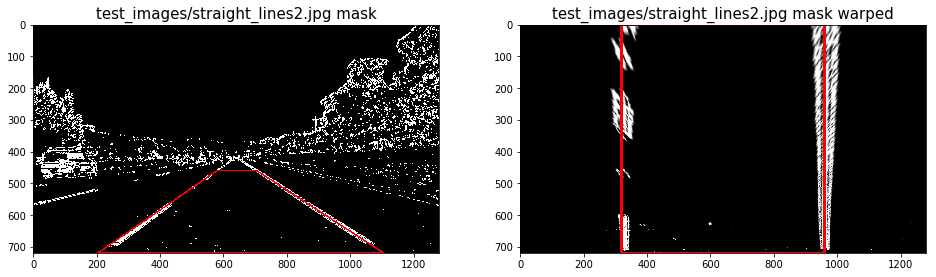

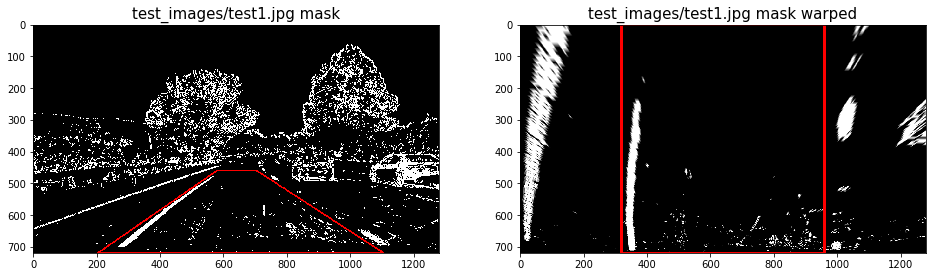

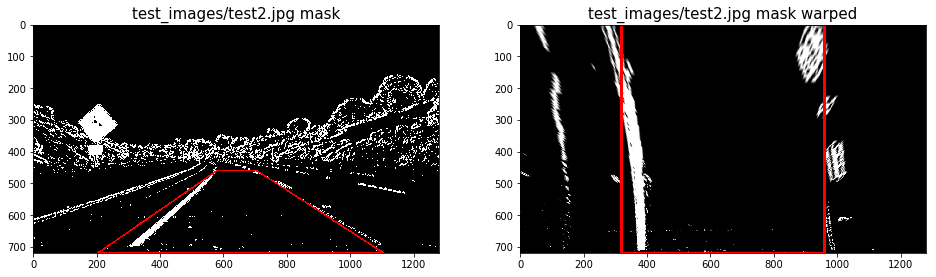

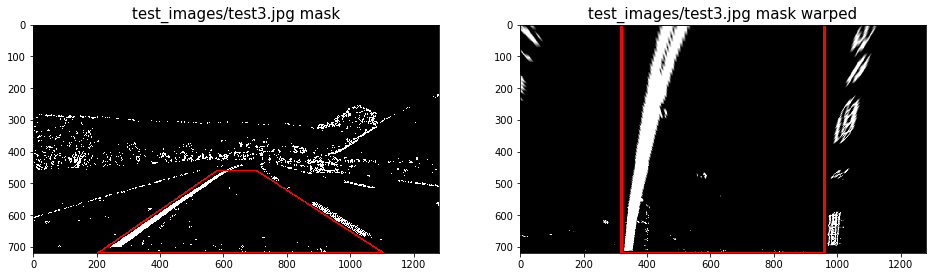

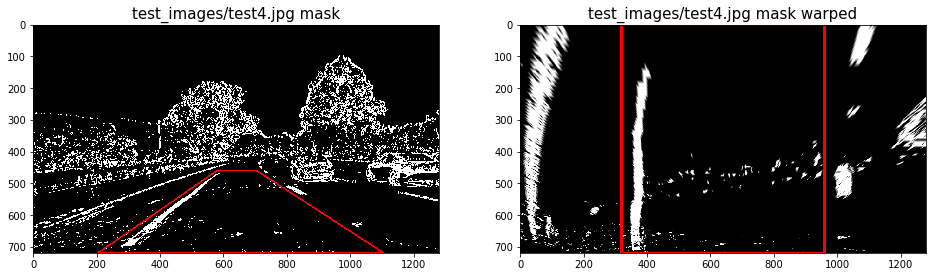

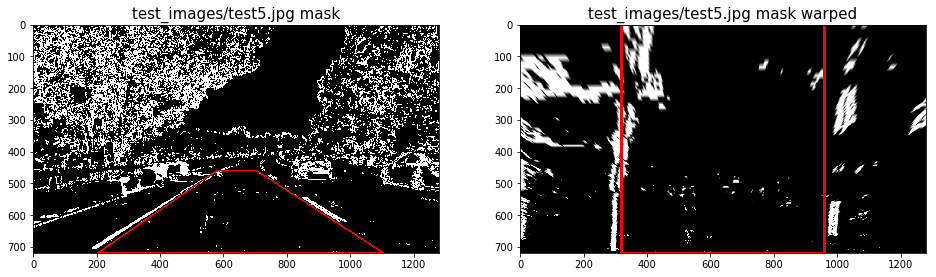

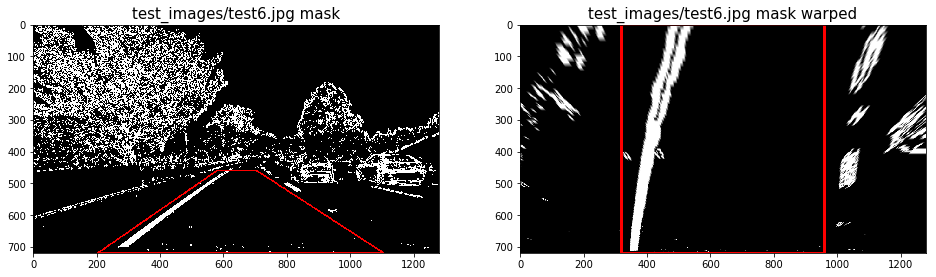

In [91]:
examplefiles = glob.glob('test_images/*.jpg')

for examplefile in examplefiles:
    
    # Load a test image
    img = mpimg.imread(examplefile)
    
    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask image
    combined,_ = get_pixel_mask(dst)
    
    # Warp binary mask images
    combined_warped = cv2.warpPerspective(combined, M, imgsize, flags=cv2.INTER_LINEAR)
    
    # Draw source and destination point "rectangles"
    cv2.polylines(combined,[srcpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=4)
    cv2.polylines(combined_warped,[dstpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=8)
    
    # Plot them
    fig, ax = plt.subplots(1, 2, figsize=(16, 5.5))
    ax[0].imshow(combined)
    ax[0].set_title(examplefile + ' mask', fontsize=15)
    ax[1].imshow(combined_warped)
    ax[1].set_title(examplefile + ' mask warped', fontsize=15)
    
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_binary_warped' + ext, bbox_inches='tight')

<a id='fit_lane'></a>

### 5. Detect lane pixels and fit to find the lane boundary.

In [104]:
def window_mask(width, height, img_ref, center,level):
    
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):

    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the
    # vertical image slice and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):
                                    int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of
        # window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_conv_max = np.max(conv_signal[l_min_index:l_max_index])
        if l_conv_max > 50:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        else:
            l_center = np.
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids


def overlay_windows(image, window_centroids, window_width, window_height):
    
    # If we found any window centroids
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.dstack([image]*3) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        
        # Get pixel centroids within each window
        lefty = np.arange(window_height//2, image.shape[0], window_height)
        leftx = np.array([centroid[0] for centroid in window_centroids[::-1]])
        righty = np.arange(window_height//2, image.shape[0], window_height)
        rightx = np.array([centroid[1] for centroid in window_centroids[::-1]])

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.arange(0,image.shape[0],10)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        pts = np.stack((np.int32(np.round(left_fitx)), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(output,[pts],False,(255,255,0), 10)
        pts = np.stack((np.int32(right_fitx), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(output,[pts],False,(255,255,0), 10)

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image,image,image)),np.uint8)
    
    return output

In [126]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def find_windows_basic(image):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack([image]*3)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = image.shape[0]//nwindows
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 350
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        print('window',window,'len(window)',len(good_right_inds))
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.arange(0,image.shape[0],10)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts = np.stack((np.int32(np.round(left_fitx)), np.int32(ploty)), axis=1).reshape((-1,1,2))
    cv2.polylines(out_img,[pts],False,(255,255,0), 10)
    pts = np.stack((np.int32(right_fitx), np.int32(ploty)), axis=1).reshape((-1,1,2))
    cv2.polylines(out_img,[pts],False,(255,255,0), 10)
    
#     import pdb; pdb.set_trace()

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    return out_img

test_images/straight_lines1.jpg
window 0 len(window) 659
window 1 len(window) 430
window 2 len(window) 55
window 3 len(window) 2995
window 4 len(window) 3506
window 5 len(window) 542
window 6 len(window) 2003
window 7 len(window) 4287
window 8 len(window) 5590
test_images/straight_lines2.jpg
window 0 len(window) 2298
window 1 len(window) 3256
window 2 len(window) 3826
window 3 len(window) 4413
window 4 len(window) 5049
window 5 len(window) 5630
window 6 len(window) 6159
window 7 len(window) 6739
window 8 len(window) 7415
test_images/test1.jpg
window 0 len(window) 2256
window 1 len(window) 967
window 2 len(window) 643
window 3 len(window) 0
window 4 len(window) 2131
window 5 len(window) 4012
window 6 len(window) 328
window 7 len(window) 1456
window 8 len(window) 1639
test_images/test2.jpg
window 0 len(window) 785
window 1 len(window) 1445
window 2 len(window) 510
window 3 len(window) 4867
window 4 len(window) 1403
window 5 len(window) 1968
window 6 len(window) 1625
window 7 len(window) 

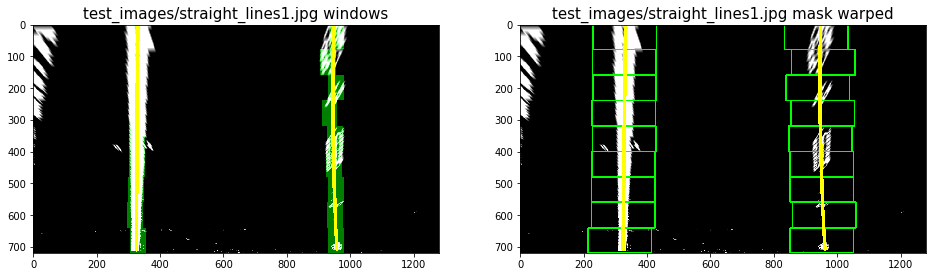

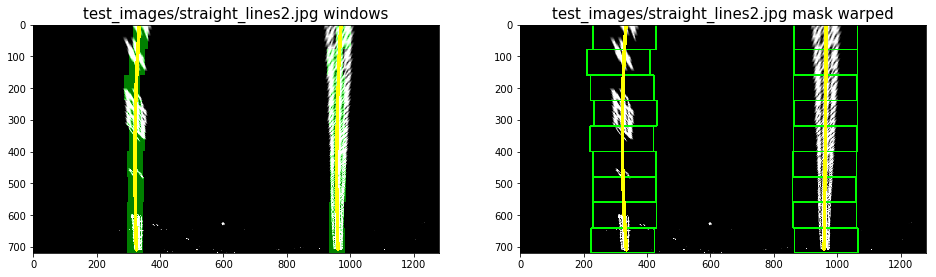

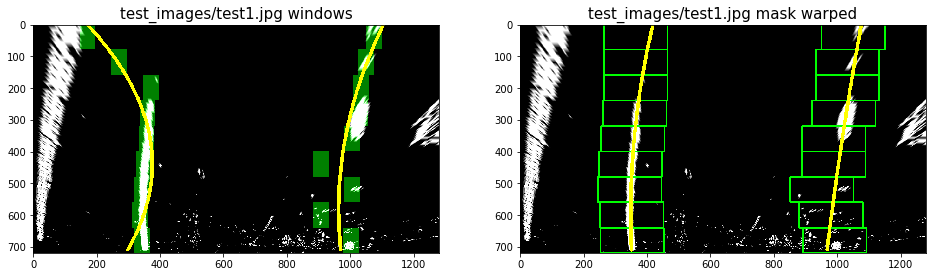

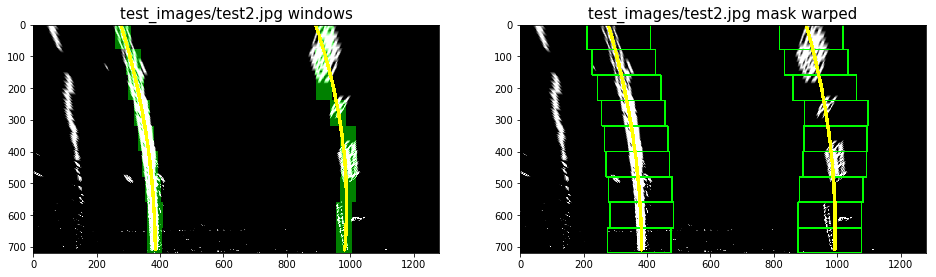

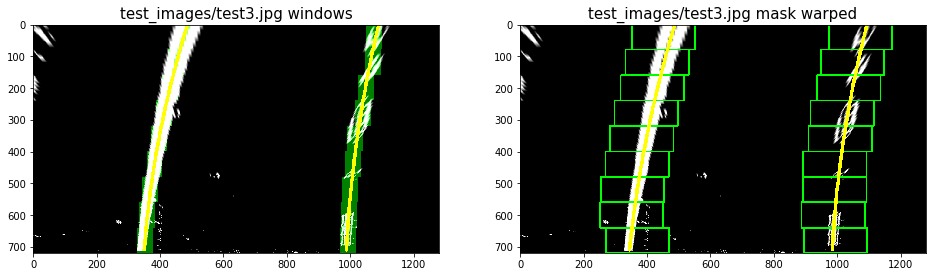

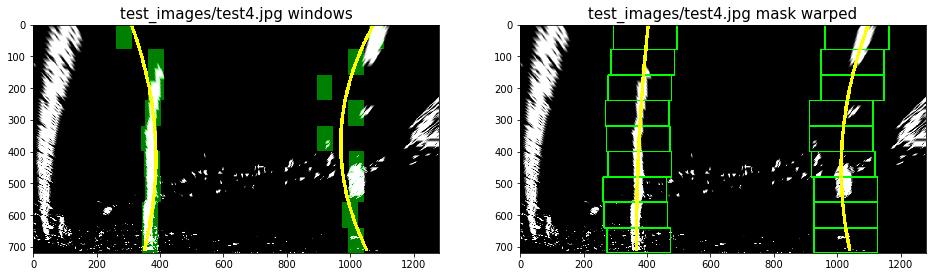

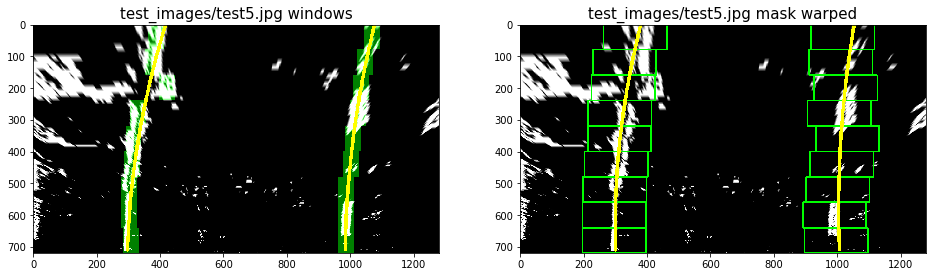

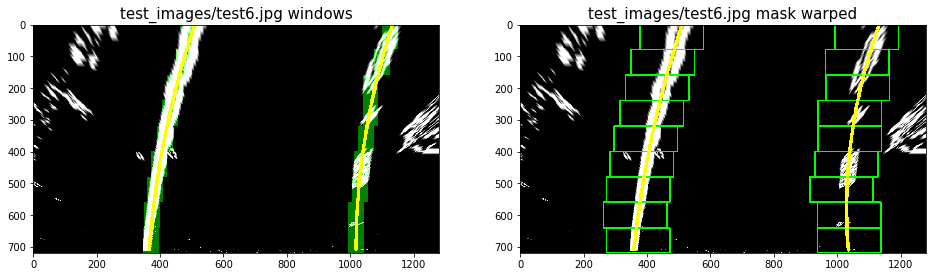

In [127]:
examplefiles = glob.glob('test_images/*.jpg')

for examplefile in examplefiles:#['test_images/test4.jpg']:#examplefiles:
    print(examplefile)
    
    # Load a test image
    img = mpimg.imread(examplefile)

    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask image
    combined,_ = get_pixel_mask(dst)

    # Warp binary mask images
    combined_warped = cv2.warpPerspective(combined, M, imgsize, flags=cv2.INTER_LINEAR)

    # Read in a thresholded image
    warped = cv2.cvtColor(combined_warped, cv2.COLOR_RGB2GRAY)

    # Compute sliding window centroids 
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    warped_windows = overlay_windows(warped, window_centroids, window_width, window_height)
    
    warped_basic = find_windows_basic(warped)

    # Plot both methods
    fig, ax = plt.subplots(1, 2, figsize=(16, 5.5))
    ax[0].imshow(warped_windows)
    ax[0].set_title(examplefile + ' windows', fontsize=15)
    ax[1].imshow(warped_basic)
    ax[1].set_title(examplefile + ' mask warped', fontsize=15)